# Exploring Conformation Space
This notebook illustrates the basis of exploring the space of possible conformers of a molecule.

Conformers are different local minima within the space of possible arrangements of a molecule that are often defined by rotating bonds within the structure.
These rotations are created by changing the ["dihedral angle"](https://en.wikipedia.org/wiki/Dihedral_angle) formed around a bond of interest.
Here, we show how to sweep over possible conformers using some tools built atop the Atomic Simulation Environment (ase).

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from confutils import get_initial_structure, get_dihedral_info, set_dihedrals_and_relax, relax_structure
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np

## Example 1: Rotating the central bond in *n*-butane
*n*-butane is a connected chain of four carbons that forms different conformers as you rotate around the bond in the center.

[![butane](https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Dihedral_angles_of_Butane.svg/281px-Dihedral_angles_of_Butane.svg.png)](https://en.wikipedia.org/wiki/Dihedral_angle#In_stereochemistry)

Here, we demonstrate computing energy as we rotate that bond.

The first step is to generate an initial structure and the bonding graph

In [2]:
atoms, g = get_initial_structure('CCCC')

In [3]:
atoms  # A description of the 3D structure

Atoms(symbols='C4H10', pbc=False)

In [4]:
g  # A description of how atoms are bonded

For reference, we compute the energy of the initial molecule by minimizing the energy of the structure through moving atomic positions (i.e., "relaxing")

In [5]:
%%time
start_energy = relax_structure(atoms)
print(f'Energy of the initial geometry: {start_energy:.2f} Ha')

Energy of the initial geometry: -4310.58 Ha
CPU times: user 2.4 s, sys: 3.35 s, total: 5.75 s
Wall time: 1.45 s


Now, we determine information about the central dihedral. We want to know which four atoms form the dihedral angle (two of the bond, two on each side of the bond) and which atoms need to be moved together as we rotate the bond.

The [utility library](./confutils.py) provided with this notebook has a function that uses the bonding graph to pick the other two atoms to form the dihedral for a bond (ideally from the backbone atoms) and then identify the atoms that must be rotated together.

In [6]:
dh1 = get_dihedral_info(g, [1, 2], backbone_atoms=[0, 1, 2, 3])
dh1

DihedralInfo(chain=[0, 1, 2, 3], group={2, 3, 9, 10, 11, 12, 13})

We denote the atoms forming the dihedral the "chain" and those that must be rotated together the "group"

In [7]:
print(f'Starting dihedral: {atoms.get_dihedral(*dh1.chain): .2f}')

Starting dihedral:  180.00


We can see that the molecule is initially in the "anti" configuration.

Next step, we scan over many dihedral angles using the `set_dihedrals_and_relax`. This function rotates the target dihedral(s), fixes the angle and the relaxes all other degrees of freedom of the molecule. For example, it allows the hydrogens in butane to move out of the way as we move the backbone.

In [8]:
phis = np.linspace(0, 360, 33)
energies = np.array([
    set_dihedrals_and_relax(atoms, [(p, dh1)]) - start_energy
    for p in tqdm(phis)
])

100%|██████████| 33/33 [01:31<00:00,  2.76s/it]


Text(0, 0.5, '$\\Delta E$')

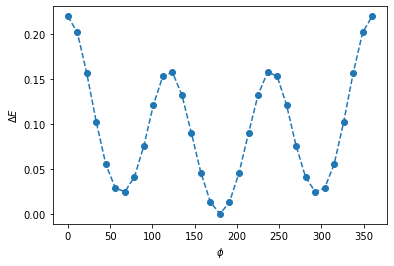

In [9]:
fig, ax = plt.subplots()

ax.plot(phis, energies, '--o')

ax.set_xlabel('$\\phi$')
ax.set_ylabel('$\Delta E$')

You can see that we now recreate the three local minima shown in the picture above: 1 anti (180) and 2 gauche configurations (60, 300)

## Example 2: Rotating two bonds in *n*-butane
We can also rotate two bonds simultaneously. We are going to pick the central and an end carbon in *n*-butane to demonstrate.

We first generate the dihedral information for an end bond

In [10]:
dh2 = get_dihedral_info(g, [2, 3], backbone_atoms=[0, 1, 2, 3])
dh2

DihedralInfo(chain=[1, 2, 3, 11], group={11, 3, 12, 13})

Now, we define a grid over which to iterate using a "mesh grid." The [`np.meshgrid`](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) creates a multi-dimensional grid where we vary over all combinations of levels in multiple lists.

In [11]:
phis = np.linspace(0, 360, 33)
phis1, phis2 = np.meshgrid(phis, phis)

In [12]:
print(f'First 10 dihedrals for the central bond:', phis1.ravel()[:10])
print(f'First 10 dihedrals for the second bond:', phis2.ravel()[:10])

First 10 dihedrals for the central bond: [  0.    11.25  22.5   33.75  45.    56.25  67.5   78.75  90.   101.25]
First 10 dihedrals for the second bond: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


`np.meshgrid` returns a multi-dimensional array for each coordinate, which we flatten to 1D arrays with `ravel`.

Raster over all of the dihedral angles (this will take 10s of minutes)

In [13]:
energies = np.array([
    set_dihedrals_and_relax(atoms, [(p1, dh1), (p2, dh2)]) - start_energy
    for p1, p2 in tqdm(zip(phis1.ravel(), phis2.ravel()), total=phis1.size)
])

100%|██████████| 1089/1089 [1:11:06<00:00,  3.92s/it]


Plot the "potential energy surface" defined by all rotations of each of these bonds

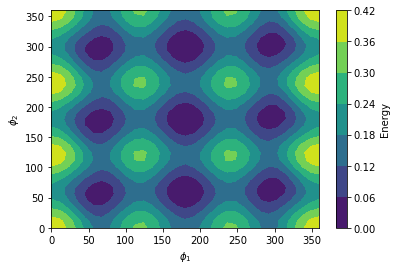

In [14]:
fig, ax = plt.subplots()

cf = ax.contourf(phis1, phis2, energies.reshape(phis1.shape))

ax.set_xlabel('$\\phi_1$')
ax.set_ylabel('$\\phi_2$')

fig.colorbar(cf, label='Energy')

You can see that we now have 9 minima. The lowest one is the original configuration ($\phi_1 = \phi_2 = 180^{\circ}$)

In [15]:
pd.DataFrame({'phi1': phis1.ravel(), 'phi2': phis2.ravel(), 'energy': energies}).to_csv('data/n-butane.csv', index=False)

## Example 3: Cysteine Conformers
The cysteine molecule has 5 rotatable bonds. For this example, we configure a system to express the energy as a function of each bond

[![cysteine](https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/jctcce/0/jctcce.ahead-of-print/acs.jctc.0c00648/20210212/images/medium/ct0c00648_0002.gif)](https://pubs.acs.org/doi/full/10.1021/acs.jctc.0c00648)

(Figure from [Fang et al. (2021)](https://pubs.acs.org/doi/full/10.1021/acs.jctc.0c00648))

Step 1 is to generate the initial geometry

In [16]:
c_atoms, c_bonds = get_initial_structure('C([C@@H](C(=O)O)N)S')

Step 2 is to define the dihedrals, which we can determine from the graph and the SMILES string.

The backbone atoms are 3 carbon atoms, the nitrogen, sulfer and the oxygen bonded with the hydrogen. Looking at the order they are listed in the string, we can write down their indices: `[0, 1, 3, 5, 6, 7]`

- `d1` is between the central carbon (second atom) and the acid carbon (fourth atom): [1, 3]
- `d2` is between the first carbon (first atom) and the central carbon: [0, 1]
- `d3` is between the central carbon and nitrogen: [1, 6]
- `d4` is between the acid carbon and the last oxygen: [3, 5]
- `d5` is between the first carbon and the sulfer: [0, 7]

In [17]:
backbone = [0, 1, 3, 5, 6, 7]

In [18]:
d1 = get_dihedral_info(c_bonds, [1, 3], backbone_atoms=backbone)
d1

DihedralInfo(chain=[0, 1, 3, 5], group={10, 3, 4, 5})

In [19]:
d2 = get_dihedral_info(c_bonds, [1, 0], backbone_atoms=backbone)

In [20]:
d3 = get_dihedral_info(c_bonds, [1, 6], backbone_atoms=backbone)

In [21]:
d4 = get_dihedral_info(c_bonds, [3, 5], backbone_atoms=backbone)

In [22]:
d5 = get_dihedral_info(c_bonds, [0, 7], backbone_atoms=backbone)

Now that we have all of these, we can compute the energy of many randomly-selected conformers

In [23]:
c_start_energy = relax_structure(c_atoms)
print(f'Initial energy for cysteine: {c_start_energy: .4f}')

Initial energy for cysteine: -19641.7084


In [24]:
phis = np.random.uniform(0, 360, size=(64, 5))  # Random confomers

In [25]:
energies = [
    set_dihedrals_and_relax(c_atoms.copy(), list(zip(phi, [d1, d2, d3, d4, d5]))) - c_start_energy
    for phi in tqdm(phis)
]

100%|██████████| 64/64 [09:23<00:00,  8.80s/it]


Make a histogram

Text(0, 0.5, 'Frequency')

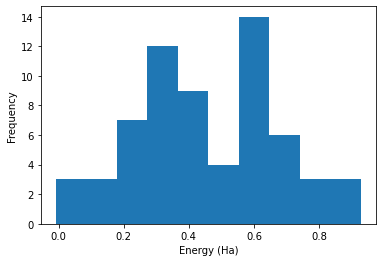

In [26]:
fig, ax = plt.subplots()

ax.hist(energies)

ax.set_xlabel('Energy (Ha)')
ax.set_ylabel('Frequency')

Save all the contents to disk for use in the homework

In [27]:
c_atoms.set_calculator()  # Remove the calculator, so the model can save

In [28]:
with open('data/cysteine-atoms.pkl', 'wb') as fp:
    pkl.dump(c_atoms, fp)

In [29]:
with open('data/dihedrals.pkl', 'wb') as fp:
    pkl.dump([d1, d2, d3, d4, d5], fp)